# Logistic Regression Model

In this notebook we model the probability of a galaxy of being quenched using a logistic regression model. First, we explore the dependence of quenching with three galaxy properties stellar mass, distance from the cluster center and line of sight velocity. Second, we explore correlations with the halo properties. In the Bayesian Hierarchical framework we will estimate for each halo the slope between quenching and a galaxy property with the constraint of the overall dataset.

In [1]:
%matplotlib inline

import pickle
# from collections import OrderedDict

import pandas as pd
import numpy as np
from scipy import stats

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_curve, roc_auc_score, confusion_matrix, accuracy_score, f1_score, 
                             precision_recall_curve) 
# from mlxtend.plotting import plot_confusion_matrix

# import theano
import pymc3 as pm

# from pymc3.variational.callbacks import CheckParametersConvergence
import statsmodels.formula.api as smf

import arviz as az
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns
from IPython.display import HTML

In [2]:
az.style.use("arviz-darkgrid")

In [3]:
cd ..

/Users/jesteves/Documents/GitHub/galaxyFormation


## Load the Data

In [4]:
import sys
sys.path.append('./scripts')
from file_loc import FileLocs
from utils import check_non_valid_number, gaussian_kde


In [5]:
fl = FileLocs(dataset='sdss')
gal0 = fl.load_catalogs('galaxy/main')

mask  = (gal0['VLOS_MASK']).astype(bool)
mask &= gal0['VOLUME_LIM_MASK'].astype(bool)
# mask &= gal0['p_infall']>0.5

gal = gal0[mask].copy()
cat = fl.load_catalogs('cluster/frac_vl')

Loading Catalog: ./data/catalogs/SDSS/groups_deCarvalho2017_R200m_galaxies_final_flag_johnnyheq_pp.csv
Loading Catalog: ./data/catalogs/SDSS/groupCatalog_Yang_deCarvalho2017_frac_vl.csv


In [6]:
# ## doing a subsample for test purposes only
# w, = np.where((gal['Yang']==2)|(gal['Yang']==4))
# gal = gal[w].copy()

In [7]:
gid = np.array(gal['Yang'])

zgal = np.array(gal['z'])
Mr   = np.array(gal['Mr'])

log_smass = np.array(gal['mass'])
smass = 10**log_smass
redshift = np.array(gal['redshift'])

rn = np.array(gal['Rm'])
vn = np.array(gal['vlosn'])
morph_type = np.array(gal['TType'])
ssfr = np.array(gal['ssfr'])

# sfr classification
sf   = np.array(gal['SF']).astype(int)
qf   = (1-sf).astype(int)

# morphological classification
sp   = np.where(gal['TType'] > 0, 1, 0).astype(int)
ell  = np.where(gal['TType'] <=0, 1, 0).astype(int)
s0   = check_non_valid_number(gal['Pbulge'])
s0[np.isnan(s0)] = 0.

# b/t definition
bt = np.array(gal['BT'])
bt2 = np.where(bt>=0.5,1.,bt)
bt2 = np.where(bt<0.5,0.,bt2)

# dynamical probabilities
Pi   = np.array(gal['p_infall'])
Po   = np.array(gal['p_orbital'])
Pn   = np.array(gal['p_interlopers'])
Pf = np.where(rn>2,Pn,0.)

m200 = np.array(gal['M200c'])

# mask
bt_mask = bt>=0.

# hard classification 
orbital = np.array(gal['orbital']=='True').astype(bool)
infall = np.array(gal['infall']=='True').astype(bool)
interlopers = np.array(gal['interlopers']=='True').astype(bool)

In [8]:
gal = 0

## Quenching Model

The likelihood is:
$$
P(Quenched, Galaxy | R, M_{\star}, \sigma,) = Logit(R,M_{\star}, \sigma) \times Bernoulli(p_{infall})
$$

With the Logit model and the linear relation
$$
y = b_0 + b_1 (R/R_{200m}) + b_{2} (M_{\star}/M_0) + b_3 \sigma
$$

In [9]:
M0 = 1e10
data = {'clusters': gid,'quenching':qf,
        'Rn':np.log10(rn),'lnMs':np.log10(smass/M0),'Vn':np.abs(vn)}
data = pd.DataFrame(data)

## Simple Model

In [10]:
simple_model = 'quenching ~ Rn + lnMs + Vn'

In [11]:
# # only infall galaxies
# prob = Pi+Po
# idx = np.random.choice(len(data),int(np.sum(prob)),p=prob/np.sum(prob))
idx, = np.where(orbital | infall)

In [12]:
model = smf.logit(formula=simple_model, data=data.iloc[idx])
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.515514
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              quenching   No. Observations:                26135
Model:                          Logit   Df Residuals:                    26131
Method:                           MLE   Df Model:                            3
Date:                Fri, 10 Jun 2022   Pseudo R-squ.:                  0.2282
Time:                        07:15:23   Log-Likelihood:                -13473.
converged:                       True   LL-Null:                       -17456.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0343      0.025     -1.347      0.178      -0.084       0.016
Rn            -1.3664      0.

In [13]:
result.params.Intercept


-0.034303935237354796

In [14]:
result.normalized_cov_params

,Intercept,Rn,lnMs,Vn
Intercept,0.000648,-0.000140,-0.000253,-0.000988
Rn,-0.000140,0.001764,-0.000168,0.000588
lnMs,-0.000253,-0.000168,0.001162,-0.000007
Vn,-0.000988,0.000588,-0.000007,0.002654


In [15]:
def print_map(result):
    return pd.Series({k: np.asscalar(v) for k, v in result.items()})
                     

In [16]:
y_simple = data['quenching']
x_n = 'Rn' 
x_c = data[x_n].values

with pm.Model() as model_simple:
    # random variables for the coefficient with
    # uninformative priors for each parameter
    α = pm.Normal('α', mu=result.params.Intercept, sd=0.5)
    β = pm.Normal('β', mu=result.params.Rn, sd=0.5)
    
    # Transform random variables into vector of probabilities 
    μ = α + pm.math.dot(x_c, β)    
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    
    # The decision boundary
    db = pm.Deterministic('db', 10**(-α/β))
    
    # Bernoulli random vector with probability of success
    # given by sigmoid function and actual data as observed
    y = pm.Bernoulli(name='logit', p=θ, observed=y_simple)

    trace_simple = pm.sample(2000, tune=1000, chains=4, init = 'adapt_diag', cores=5)

/usr/local/anaconda/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 5 jobs)
NUTS: [β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 87 seconds.


In [17]:
az.summary(trace_simple, var_names=['α', 'β', 'db'])


Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/anaconda/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,0.346,0.011,0.327,0.366,0.0,0.0,5846.0,5375.0,1.0
β,-1.205,0.029,-1.261,-1.151,0.0,0.0,6012.0,5295.0,1.0
db,0.287,0.009,0.270,0.305,0.0,0.0,6078.0,5589.0,1.0


Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/anaconda/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


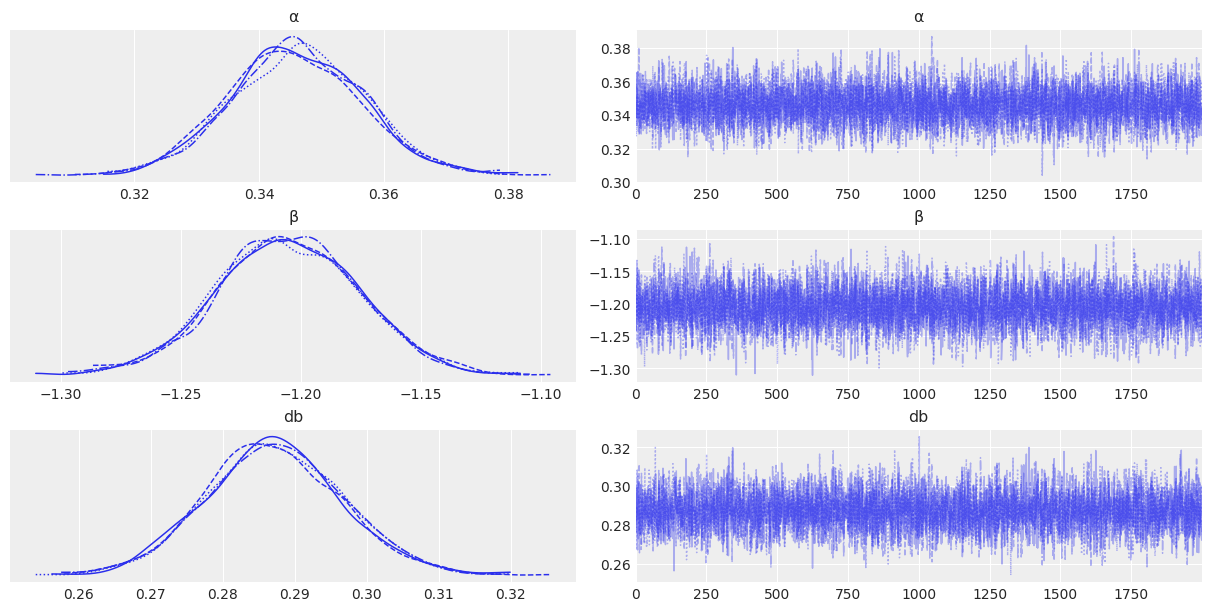

In [18]:
az.plot_trace(trace_simple, var_names=["α", "β", "db"]);

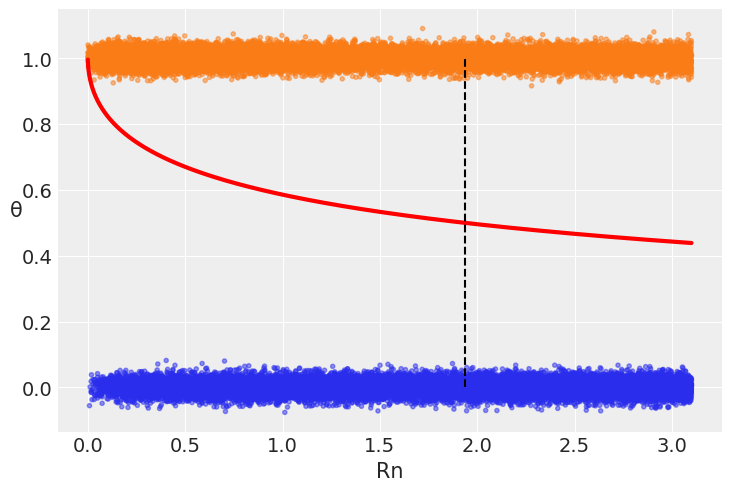

In [19]:
theta = trace_simple['θ'].mean(axis=0)
idx = np.argsort(x_c)
plt.plot(10**x_c[idx], theta[idx], color='red', lw=3)
plt.vlines(10**trace_simple['db'].mean(), 0, 1, color='k', ls='--')
plt.scatter(10**x_c, np.random.normal(y_simple, 0.02), marker='.', alpha=0.5, 
            color=[f'C{x}' for x in y_simple])
plt.xlabel(x_n)
plt.ylabel('θ', rotation=0)
locs, _ = plt.xticks()
# plt.xticks(locs, np.round(locs + x_c.mean(), 1));

In [12]:
# theta = trace_simple['θ'].mean(axis=0)
# idx = np.argsort(x_c)
# plt.plot(x_c[idx], theta[idx], color='red', lw=3)
# plt.vlines(trace_simple['db'].mean(), 0, 1, color='k', ls='--')
# plt.scatter(x_c, np.random.normal(y_simple, 0.02), marker='.', alpha=0.5, 
#             color=[f'C{x}' for x in y_simple])
# plt.xlabel(x_n)
# plt.ylabel('θ', rotation=0)
# locs, _ = plt.xticks()
# # plt.xticks(locs, np.round(locs + x_c.mean(), 1));

In [21]:
ppc = pm.sample_posterior_predictive(trace_simple, model=model_simple, samples=500)
preds = np.rint(ppc['logit'].mean(axis=0)).astype('int')
y_score = np.mean(ppc['logit'], axis=0)

/usr/local/anaconda/lib/python3.8/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [22]:
print('Accuracy of the simplest model:', accuracy_score(data['quenching'], preds))
print('AUC score of the simplest model:', roc_auc_score(data['quenching'], y_score))

Accuracy of the simplest model: 0.5757624287904093
AUC score of the simplest model: 0.6086665965664485


In [23]:
betaM = np.mean(trace_simple['β'])
betaM

-1.2054355911795747

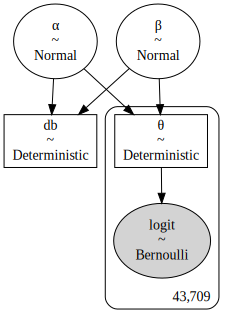

In [24]:
pm.model_to_graphviz(model_simple)


In [13]:
betaM= 1.2054355911795747

## Logistic Model

The lostic regression model on pymc3 can be implemented as invlogit and Bernoulli. The Bernoulli can be parametrized as logit function according to pymc3 documentation.
https://docs.pymc.io/en/latest/api/distributions/generated/pymc.Bernoulli.html \

Implementation for the lostic regression model is based on this example:
..

Implementation for the hierachichal model comes from here:
https://docs.pymc.io/en/latest/api/distributions/generated/pymc.Bernoulli.html

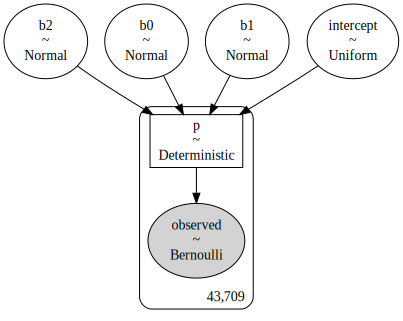

In [14]:
with pm.Model() as first_model:
    # priors:
    intercept = pm.Uniform('intercept', lower=-10, upper= 10)
    b0 = pm.Normal("b0", mu=0.275, sigma=0.3)
    b1 = pm.Normal("b1", mu=betaM, sigma=0.3)
    b2 = pm.Normal("b2", mu=0.211, sigma=0.3)
            
    #pm.distributions.discrete.Bernoulli('class', p=prob_class)
    
    # Transform random variables into vector of probabilities p(y_i=1)
    # according to logistic regression model specification.
    likelihood = pm.Deterministic('p',pm.math.sigmoid(intercept + b0 * data.Rn + b1 * data.lnMs + b2 * data.Vn))
        
    # Bernoulli random vector with probability of success
    # given by sigmoid function and actual data as observed
    logit = pm.Bernoulli('observed', p=likelihood, observed=data.quenching)    
    
pm.model_to_graphviz(first_model)

In [ ]:
with first_model:
    #fit the data 
    start=pm.find_MAP()
    step=pm.Metropolis()
    
    #samples from posterior distribution 
    trace=pm.sample(15000, step=step, start=start, return_inferencedata=False, discard_tuned_samples=True,)
    burned_trace=trace[5000:]

<ipython-input-15-b77b0e20f247>:7: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace=pm.sample(15000, step=step, start=start, return_inferencedata=False, discard_tuned_samples=True,)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [b2]
>Metropolis: [b1]
>Metropolis: [b0]
>Metropolis: [intercept]


Sampling 4 chains for 1_000 tune and 15_000 draw iterations (4_000 + 60_000 draws total) took 752 seconds.


In [ ]:
az.summary(burned_trace, var_names=['intercept','b0','b1','b2'])


In [ ]:
az.plot_trace(burned_trace, var_names=["intercept","b0","b1","b2"]);

In [ ]:
coeffs = ["intercept","b0","b1","b2"]

interval=dict()
for item in coeffs:
    out = np.array([burned_trace[item].mean(), burned_trace[item].std()]) 
    interval[item]=np.append(out, pm.stats.hdi(burned_trace[item])) #compute 95% high density interval

interval0=pd.DataFrame(interval,index=['mean','std','lower','upper'])


In [ ]:
interval0

In [ ]:
trace = burned_trace = 0

In [ ]:
county_idxs, counties = pd.factorize(data.clusters.to_numpy())
coords = {
    "county": counties,
    "obs_id": np.arange(len(county_idxs)),
}

In [ ]:
with pm.Model(coords=coords) as hierarchical_logistic_model:
    # Independent parameters for each county
    # cluster ID
    cidx = pm.Data("county_idx", county_idxs, dims="obs_id")

    # priors:
    intercept = pm.Normal('intercept', mu=interval0.intercept[0], sigma=interval0.intercept[1])
    b0 = pm.Normal("b0", mu=interval0.b0[0], sigma=interval0.b0[1])
    b1 = pm.Normal("b1", mu=interval0.b1[0], sigma=interval0.b1[1])
    b2 = pm.Normal("b2", mu=interval0.b2[0], sigma=interval0.b2[1])
    
    #s0 = pm.Exponential("s0", 1.0)
    #s1 = pm.Exponential("s1", 1.0)
    #s2 = pm.Exponential("s2", 1.0)
    #s3 = pm.Exponential("s3", 1.0)
    
    # slopes & intercept for each cluster
    beta_1 = pm.Normal('b0_cls', mu=b0, sigma=3*interval0.b0[1], dims="county")
    beta_2 = pm.Normal('b1_cls', mu=b1, sigma=3*interval0.b1[1], dims="county")
    beta_3 = pm.Normal('b2_cls', mu=b2, sigma=3*interval0.b2[1], dims="county")
    
    #pm.distributions.discrete.Bernoulli('class', p=prob_class)
    
    # Transform random variables into vector of probabilities p(y_i=1)
    # according to logistic regression model specification.
    line = intercept + beta_1[cidx] * data.Rn + beta_2[cidx] * data.lnMs + beta_3[cidx] * data.Vn
    likelihood = pm.Deterministic('p',pm.math.sigmoid(line))

    # Bernoulli random vector with probability of success
    # given by sigmoid function and actual data as observed
    logit = pm.Bernoulli('observed', p=likelihood, observed=data.quenching)
    
pm.model_to_graphviz(hierarchical_logistic_model)

In [ ]:
with hierarchical_logistic_model:
    #fit the data 
    start=pm.find_MAP()
    step = pm.Metropolis()
    
    #samples from posterior distribution 
    trace=pm.sample(20000, tune=2000, step=step, start=start, cores=7,
                    return_inferencedata=False, discard_tuned_samples=True,)
    burned_trace=trace[10000:]

In [ ]:
az.summary(burned_trace, var_names=['intercept','b0','b1','b2'])#,'b0_cls','b1_cls','b2_cls'])


In [ ]:
az.plot_trace(burned_trace, var_names=['intercept','b0','b1','b2','b0_cls','b1_cls','b2_cls']);

In [ ]:
coeffs = ["intercept","b0","b1","b2"]

interval=dict()
for item in coeffs:
    out = np.array([burned_trace[item].mean(), burned_trace[item].std()]) 
    interval[item]=np.append(out, pm.stats.hdi(burned_trace[item])) #compute 95% high density interval

interval = pd.DataFrame(interval,index=['mean','std','lower','upper'])


In [ ]:
interval

In [ ]:
theta = burned_trace['p'].mean(axis=0)
idx = np.argsort(x_c)
plt.plot(10**x_c[idx], theta[idx], color='red', lw=3)
# plt.vlines(10**burned_trace['db'].mean(), 0, 1, color='k', ls='--')
plt.scatter(10**x_c, np.random.normal(y_simple, 0.02), marker='.', alpha=0.5, 
            color=[f'C{x}' for x in y_simple])
plt.xlabel(x_n)
plt.ylabel('θ', rotation=0)
locs, _ = plt.xticks()
# plt.xticks(locs, np.round(locs + x_c.mean(), 1));

In [ ]:
ppc = pm.sample_posterior_predictive(burned_trace, model=hierarchical_logistic_model, samples=500)
preds = np.rint(ppc['observed'].mean(axis=0)).astype('int')
y_score = np.mean(ppc['observed'], axis=0)

In [ ]:
print('Accuracy of the simplest model:', accuracy_score(data['quenching'], preds))
print('AUC score of the simplest model:', roc_auc_score(data['quenching'], y_score))

In [ ]:
def lm_full(trace, Rn, Ms, Vn):
    shape = np.broadcast(Rn, Ms, Vn).shape
    x_norm = np.asarray([np.broadcast_to(x, shape) for x in [ Rn, Ms, Vn]])
    
    return 1 / (1 + np.exp(-(trace['intercept'] + 
                             trace['b0']*np.log10(x_norm[0]) + 
                             trace['b1']*x_norm[1] +
                             trace['b2']*x_norm[2])))

#x = data.to_numpy()[:,2:]
M0=1e10
lm = lambda x, samples: lm_full(samples, x, np.log10(10e9/M0), 1.)
lm2 = lambda x, samples: lm_full(samples, x, np.log10(10e10/M0), 1.)
lm3 = lambda x, samples: lm_full(samples, x, np.log10(10e11/M0), 1.)

In [ ]:
min_age = 0.#10**min(data.Rn)
max_age = 3.#max(data.Rn)

# Plot the posterior predictive distributions of P(deposit = yes) vs. duration
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(
    min_age, max_age, 1000), lm=lm, samples=100, color="blue", alpha=.7)
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(
    min_age, max_age, 1000), lm=lm2, samples=100, color="green", alpha=.7)
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(
    min_age, max_age, 1000), lm=lm3, samples=100, color="red", alpha=.7)

# blue_line = mlines.Line2D(['lm'], [], color='b', label='failure')
# green_line = mlines.Line2D(['lm2'], [], color='g', label='unknown')
# red_line = mlines.Line2D(['lm3'], [], color='r', label='success')
# plt.legend(handles=[blue_line, green_line, red_line], loc='lower right')
plt.ylabel("P_quenching")
plt.xlabel("R/R200m")
plt.show()

In [ ]:
# we will use as priors

In [ ]:
az.summary(trace_simple, var_names=['α', 'β', 'db'])


# Joint Model

## Bernouli Model

Draw galaxies from the `p_classification` output.

In [ ]:
with pm.Model(coords=coords) as draw_model:
    Pc = pm.Data("p", Po, dims="obs_id")
    prob = pm.Bernoulli(name='pgal', p=Pc, dims="obs_id")
    #trace_h = pm.sample(2000)

In [ ]:
pm.model_to_graphviz(draw_model)

In [ ]:
def get_hyperprior_model(data, N_samples):
    with pm.Model() as model_h:
        μ = pm.Beta('μ', 1., 1.) # hyperprior
        κ = pm.HalfNormal('κ', 10) # hyperprior
        alpha = pm.Deterministic('alpha', μ*κ)
        beta = pm.Deterministic('beta', (1.0-μ)*κ)
        θ = pm.Beta('θ', alpha=alpha, beta=beta) # prior, len(N_samples) = 3
        y = pm.Bernoulli('y', p=θ, observed=data)
        trace_h = pm.sample(2000)
    az.plot_trace(trace_h)
    print(az.summary(trace_h))
    return(model_h) 

In [ ]:
N_samples = [np.sum(Po),np.sum(Pi),np.sum(Pn)]

In [ ]:
model = get_hyperprior_model(Pi, len(Pi))
pm.model_to_graphviz(model)

In [ ]:
with pm.Model(coords=coords) as manual_logistic_model:
    # Independent parameters for each county
    # cluster ID
    cidx = pm.Data("county_idx", county_idxs, dims="obs_id")
    
    # class probabibility
    #Pc = pm.Data("p", Po, dims="obs_id")
    Qf = pm.Data("Quenching", data.quenching, dims="obs_id")
    
    # x variables
    Rn = pm.Data("Rn", data.Rn, dims="obs_id")
    Vn = pm.Data("Vn", data.Vn, dims="obs_id")
    Ms = pm.Data("lnMs", data.lnMs, dims="obs_id")
    
    # Hyperpriors:
    b0 = pm.Normal("b0", mu=0.0, sigma=10.0)
    b1 = pm.Normal("b1", mu=betaM, sigma=1.0)
    b2 = pm.Normal("b2", mu=0.0, sigma=20.0)
    b3 = pm.Normal("b3", mu=0.0, sigma=20.0)
    
    s0 = pm.Exponential("s0", 1.0)
    s1 = pm.Exponential("s1", 1.0)
    s2 = pm.Exponential("s2", 1.0)
    s3 = pm.Exponential("s3", 1.0)
    
    # slopes & intercept for each cluster
    intercept = b0 #pm.Normal('intercept', mu=b0, sigma=s0, dims="county")
    beta_1 = pm.Normal('b_1_cls', mu=b1, sigma=s1, dims="county")
    beta_2 = pm.Normal('b_2_cls', mu=b2, sigma=s2, dims="county")
    beta_3 = pm.Normal('b_3_cls', mu=b3, sigma=s3, dims="county")
    
    #pm.distributions.discrete.Bernoulli('class', p=prob_class)
    
    # Transform random variables into vector of probabilities p(y_i=1)
    likelihood = pm.invlogit(intercept + beta_1[cidx] * Rn 
                             + beta_2[cidx] * Ms + beta_3[cidx] * Vn)
        
    # Bernoulli random vector with probability of success
    # given by sigmoid function and actual data as observed
    logit = pm.Bernoulli(name='logit', p=likelihood, observed=Qf, dims="obs_id")    
    
pm.model_to_graphviz(manual_logistic_model)

In [ ]:
pm.model_to_graphviz(manual_logistic_model)

In [ ]:
with manual_logistic_model:
    hierarchical_trace = pm.sample(2000)

In [ ]:
az.summary(hierarchical_trace)


In [ ]:
help(pm.traceplot)

In [ ]:
pm.traceplot(hierarchical_trace, var_names=["b1","b2","b3"],
             filter_vars="like", 
            figsize= (8, 12))
plt.show()

In [ ]:
# az.plot_forest(
# #     manual_logistic_model, avar_names=["beta", "a_county"], r_hat=True, combined=True, textsize=9
# );


## The Joint Distribution

In [ ]:
with pm.Model(coords=coords) as manual_logistic_model:
    Pc = pm.Data("p", Po, dims="obs_id")
    prob = pm.Bernoulli('draw', p=Pc, dims="obs_id")
    
    def joint(logit, bern):
        return logit*bern
    
    L = pm.DensityDist('L', joint, observed={'logit': logit, "bern": prob})

In [ ]:
with pm.Model(coords=coords) as manual_logistic_model:
    # Independent parameters for each county
    # cluster ID
    cidx = pm.Data("county_idx", county_idxs, dims="obs_id")
    
    # class probabibility
    Pc = pm.Data("p", Po, dims="obs_id")
    Qf = pm.Data("Quenching", qf, dims="obs_id")
    
    # x variables
    Rn = pm.Data("Rn", rn, dims="obs_id")
    Vn = pm.Data("Vn", vn, dims="obs_id")
    Ms = pm.Data("Ms", np.log10(smass/1e10), dims="obs_id")
    
    # Hyperpriors:
    b0 = pm.Normal("b0", mu=0.0, sigma=20.0)
    b1 = pm.Normal("b1", mu=0.0, sigma=20.0)
    b2 = pm.Normal("b2", mu=0.0, sigma=20.0)
    b3 = pm.Normal("b3", mu=0.0, sigma=20.0)
    
    s0 = pm.Exponential("s0", 1.0)
    s1 = pm.Exponential("s1", 1.0)
    s2 = pm.Exponential("s2", 1.0)
    s3 = pm.Exponential("s3", 1.0)
    
    # slopes & intercept for each cluster
    intercept = b0 #pm.Normal('intercept', mu=b0, sigma=s0, dims="county")
    beta_1 = pm.Normal('b_1_cls', mu=b1, sigma=s1, dims="county")
    beta_2 = pm.Normal('b_2_cls', mu=b2, sigma=s2, dims="county")
    beta_3 = pm.Normal('b_3_cls', mu=b3, sigma=s3, dims="county")
    
    #pm.distributions.discrete.Bernoulli('class', p=prob_class)
    
    # Transform random variables into vector of probabilities p(y_i=1)
    # according to logistic regression model specification.
    succsess = pm.logit(intercept + beta_1[cidx] * Rn 
                         + beta_2[cidx] * Ms + beta_3[cidx] * Vn)

#     likelihood = pm.invlogit(intercept + beta_1[cidx] * Rn 
#                              + beta_2[cidx] * Ms + beta_3[cidx] * Vn)
        
    # Bernoulli random vector with probability of success
    # given by sigmoid function and actual data as observed
    Pc = pm.Data("p", Po, dims="obs_id")
    prob = pm.Bernoulli('draw', p=Pc, observed=succsess, dims="obs_id")
    likelihood = 


    logit = pm.Bernoulli(name='logit', p=likelihood, dims="obs_id")    
    mix = pm.Bernoulli('new', p=prob, observed=likelihood, dims="obs_id")
    final = pm.
    # now model the classification probabilities
    
    
# pm.model_to_graphviz(manual_logistic_model)

In [ ]:
pm.model_to_graphviz(manual_logistic_model)

In [ ]:
# define the classification probabilities
    bern = pm.Potential('bernoulli', qf * tt.log(p) + (1-qf) * tt.log(1 - p))


In [ ]:
# https://discourse.pymc.io/t/likelihood-given-by-product-of-two-distributions/1614/3
# to join the likelihoods
    def joint(gamma, theta):
        return gamma * theta

    # Likelihood (sampling distribution) of observations
    L = pm.DensityDist('L', joint, observed={'gamma': gamma, 'theta': theta})

In [ ]:
# # Inference button (TM)!
# with manual_logistic_model:
#     hierarchical_trace = pm.sample(2000, tune=2000, target_accept=0.9, cores=6)

In [ ]:
az.plot_forest(
    varying_intercept_trace, var_names=["beta", "a_county"], r_hat=True, combined=True, textsize=9
);


In [ ]:
pm.plot_trace(trace);


In [ ]:
trace.varnames

In [ ]:
plt.hist(trace['beta_3'])

In [ ]:
# https://www.srose.biz/wp-content/uploads/2020/08/Bayesian-logistic-regression-with-pymc3.html